# Recurrent Neural Networkd

In this Lab we learn how to solve sequential problems using RNNs. We will describe how can RNNs be implemented with PyTorch and evaluate their results in real problems.

## Imports

In [19]:
import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import scipy.misc
import random

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler

#PyTorch
import torch
from torch import nn
from torch.optim import Adam, SGD
#from torchsummary import summary
from torch.autograd  import Variable

# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG

The first problem we consider is time series prediction with an RNN. Given a sequence of k contiguous points of the time series, $(t_{r},t_{r+1},\dots,t_{r+k})$ that are used as inputs, we will try to predict the sequence $(t_{r+1},t_{r+2},\dots,t_{r+k+1})$. Therefore, for each single point at time $t$, the target variable is the time series value at time $t+1$.

## Time Series Example

In [20]:
# The function belows generates a particular time series.
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

To train the network we need sequences of size $k$ extracted from the time series. They are randomly selected using the function "next_batch" that outputs a set of <batch_size> training points, each point corresponding to a sequence of size k (in the function this size k is called "n_steps"). 

In [21]:
t_min, t_max = 0, 30
resolution = 0.1

# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In the next cell, we visualize the time series, and an example of training pairs $(x,y)$, where $x$ is a sequence of $k=20$ points and $y$ is the target sequence of $20$ points, the ones obtained by shifting $x$ only one position. 



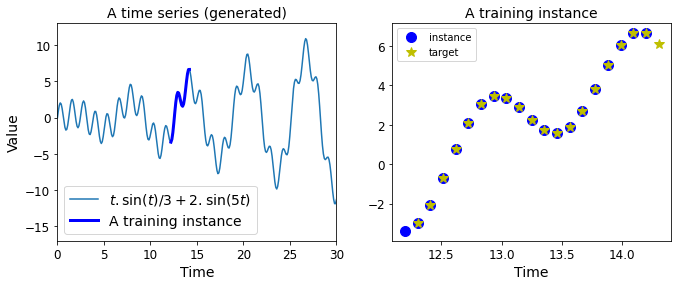

In [22]:
# The time series and the example of (x,y) are shown 

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


#save_fig("time_series_plot")
plt.show()

In [23]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('data_akbilgic.csv')
df

,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802
...,...,...,...,...,...,...,...,...,...,...
531,16-Feb-11,0.008599,0.013400,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
532,17-Feb-11,0.009310,0.015977,0.003071,-0.001186,0.000345,0.002620,0.001686,-0.000581,0.001039
533,18-Feb-11,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938
534,21-Feb-11,-0.013069,-0.013706,-0.020742,-0.014239,-0.011275,0.001358,-0.011942,-0.012615,-0.000958


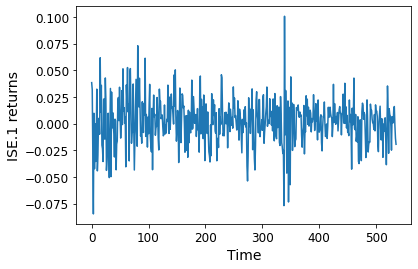

In [24]:
plt.plot(df['ISE.1'])
plt.xlabel("Time")
plt.ylabel("ISE.1 returns")
plt.show()

## Train/Test Split

Implement a train test split function without using sklearn

In [25]:
df_size = df.shape[0]

#Create targets
#df_targets = df.iloc[1:,1:]
#df_targets.columns = df_targets.columns + '_target'
#df_targets = df_targets.reset_index()
#df[df_targets.columns] = df_targets

#Split in train and test
#df.drop('index', axis=1, inplace=True)
#df.dropna(inplace=True)
split = df.index<=df_size*0.7
df_train = df[split]
df_test = df[~split]

## Batchify the Data

Below you will need to implement a fucntion that returns a a batch to feed the RNN

In [26]:
# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_stock_batch(batch_size, n_steps, df_base):
    t_min = 0
    t_max = df_base.shape[0]
  
    # The inputs will be formed by 8 sequences taken from
    # 8 time series [ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM]
    x = np.zeros((batch_size,n_steps,7))
    
    # We want to predict the returns of the Istambul stock
    # taken into consideration the previous n_steps days
    y = np.zeros((batch_size,n_steps,1))

    # We chose batch_size random points from time series x-axis

    starting_points = np.random.randint(0,t_max-n_steps-1,size=batch_size)    
    #print(starting_points)

    # We create the batches for x using all time series (8) between t and t+n_steps    
    # We create the batches for y using only one time series between t+1 and t+n_steps+1
    
    for k in np.arange(batch_size):
        lmat = []
        for j in np.arange(n_steps+1):
            lmat.append(df_base.iloc[starting_points[k]+j,2:].values)  
            mat = np.array(lmat)
        # The x values include all columns (mat[:n_steps,:]), these are ([ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM])
        # and TS values in mat between 0 and n_steps
        x[k,:,:] = mat[:n_steps,1:]
        
        # The y values include only column 0 (mat[1:n_steps+1,0]), this is ([ISE.1]) 
        # and TS values in mat between 1 and n_steps+1
        y[k,:,0] = mat[1:n_steps+1,0]
   

    return x,y

## Parameters
Now we need to define the parameters of our RNN

In [34]:
# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
n_inputs = 7

# n_steps is the size of the contiguous sequence that is taken from the TS
# it coincides with the number of time steps for the RNN
n_steps = 10

# There is one layer of X recurrent neurons together
n_neurons = 15

# The ouput will be a single sequence
n_outputs = 1

#number of hidden layers
n_layers = 3

#number of batches per loop
n_batch_size = 3

## Architecture

In the next cell we will define our RNN architecture. For this example we will use a default torch architecture.

In [43]:
class Model(nn.Module):
    def __init__(self, input_size, outputs, hidden_size, n_layers, n_batch_size):
        super(Model, self).__init__()
        
        #Defining the layers
        self.hidden_dim = hidden_size
        self.n_layers = n_layers
        self.batches = n_batch_size
        self.outputs = outputs
        
        #RNN layer
         
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True) 
        
        #Fully  connected layer
        
        self.fc = nn.Linear(n_batch_size * hidden_size, n_batch_size * outputs) # batch_size * outputs
        self.relu= nn.ReLU()
        
    def forward(self, x):
        
        batch_size = x.size(0)
        
        #intialize hidden state for the first input
        hidden = self.init_hidden(batch_size)
        
        #pass the input and hidden state through the rnn and obtainign outputs
        out, hidden =self.rnn(x, hidden)
        hidden_last = hidden[-1]
        out = self.relu(hidden_last.flatten()) 
        
        out = self.fc(out)
        
        return out
    
    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

## Optimizer and Loss Function

The loss functio will comput the gradients and the optimizer will apply them. In the following cell we will need to initialize our model and create the optimizer and the loss function. Select the ones that you think are most suited for the task.

In [44]:
# We initialize our RNN model to pass it to the optimizer

model = Model(n_inputs, n_outputs, n_neurons, n_layers, n_batch_size)

# What would be an adecuate loss function?
criterion =  nn.L1Loss()

# optimizer to apply the gradients
optim = Adam(model.parameters(), lr=0.5)



## Trainning Loop

We will define the training loop for our model. This training loop is a little different than the usual. A normal training loop is epoch based meaning that it trains for a certain ammount of epochs seeing the whole dataset in each epoch. For this model we will use an 'online' training which mean we will generate the batches the moment before feeding it with no real regard for running trhough the entire dataset.

    0 L1: 0.0618
   10 L1: 1.2659
   20 L1: 0.4076
   30 L1: 1.3952
   40 L1: 0.5947
   50 L1: 0.2877
   60 L1: 0.1056
   70 L1: 0.5811
   80 L1: 0.3626
   90 L1: 0.7899
  100 L1: 0.5154
  110 L1: 0.4966
  120 L1: 0.3319
  130 L1: 0.4104
  140 L1: 0.7838
  150 L1: 0.2328
  160 L1: 0.3939
  170 L1: 0.2215
  180 L1: 0.8832
  190 L1: 0.3823
  200 L1: 0.6272
  210 L1: 0.1949
  220 L1: 0.5438
  230 L1: 0.6469
  240 L1: 0.3709
  250 L1: 0.2567
  260 L1: 0.3578
  270 L1: 0.7462
  280 L1: 0.5152
  290 L1: 0.4902


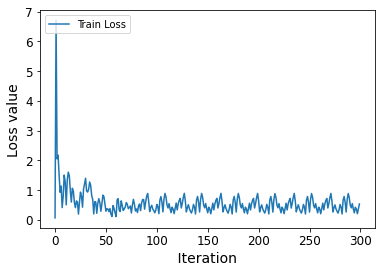

In [45]:
n_iterations = 300
batch_size = 3
#after how many operations we will print information
printing_gap = 10

#We will store the loss values here to plot them
train_loss = []
train_outputs = []
real_outputs = []

for i in range(n_iterations):
    #Get a batch
    x,y = next_stock_batch(batch_size, n_steps, df_train)
    
    #make into tensor
    x,y = torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y))
    
    #make them into torch variables in float format
    x,y = x.type(torch.FloatTensor), y.type(torch.FloatTensor)
    
    
    #Reset the gradients
    optim.zero_grad()
    
    #Get the outputs
    hn = model.forward(x)

    #detach the hidden state
    hn.detach()
    
    #compute the loss
    loss = criterion(hn, y)

    #compute the gradients
    loss.backward()

    #Apply the gradients
    optim.step()

    #Append the loss value and output
    train_loss.append(loss.detach())

    if i % printing_gap == 0:
        #Print the information
        print(f'{i:5.0f} L1: {loss:.4f}')


plt.plot(train_loss, label= "Train Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()



## Testing

Without updating or computing the gradients test the model in a single test batch

In [64]:
x,y = next_stock_batch(batch_size, n_steps, df_train)
x,y = torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y))
x,y = x.type(torch.FloatTensor), y.type(torch.FloatTensor)
hn = model.forward(x)
hn

tensor([-0.3791, -0.0174,  0.4728], grad_fn=<AddBackward0>)

# Visualization

In the following cell we will plot the y_true with out prediction

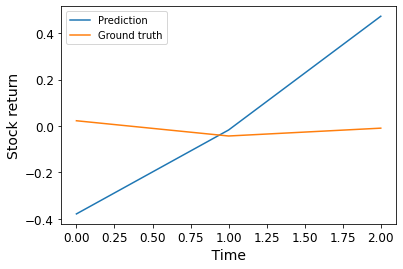

In [65]:
plt.plot(hn.detach().numpy(), label= "Prediction")
plt.plot(y[:,-1,:].detach().numpy(), label= "Ground truth")
plt.xlabel(" Time ")
plt.ylabel("Stock return")
plt.legend(loc="upper left")
plt.show()

In [67]:
x,y = next_stock_batch(30,n_steps, df_test)
x,y = torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y))
x,y = x.type(torch.FloatTensor), y.type(torch.FloatTensor)
hn = model.forward(x)
hn
plt.plot(hn.detach().numpy(), label= "Prediction")
plt.plot(y[:,-1,:].detach().numpy(), label= "Ground truth")
plt.xlabel(" Time ")
plt.ylabel("Stock return")
plt.legend(loc="upper left")
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x450 and 45x3)

tensor(0.0006)
torch.Size([50, 30, 1])


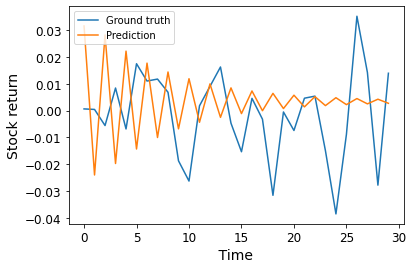

In [41]:
 #Print the ground truth sequence and the predicted sequence of a batch in test

# Extra exercises

## 1. In the previous model we used a standard RNN cell but there are better option out there try them
## 2. Add dropout and batch normalization to a more complex model using another type of cell
## 3. Create a more shopisticated model that includes at list another linear layer
## 4. Create a new trainning loop in which you validate every X batches and you save the model with better validation result
